In [36]:
# !pip install SimpleITK

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import SimpleITK as sitk
import cv2

# image_dir="/content/drive/MyDrive/Biomedicine/AI Project 2024-2025/Train"
image_dir = "/kaggle/input/ds-lung-tumor/Train-20250104T155611Z-001/Train"

# Functions

In [37]:
def load_nrrd(file_path):
    try:
        image = sitk.ReadImage(file_path)
        array = sitk.GetArrayFromImage(image)
        return array
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def load_all_images():
    df_images = pd.read_excel("/kaggle/input/ds-lung-tumor/dataset_lung.xlsx") # Read the CSV file
    display(df_images)

    nodule_images = []
    full_images   = []
    labels        = []

    for index, row in df_images.iterrows():
        noduleslice_filename = row['Nodule']
        noduleslice_path        = os.path.join(image_dir, noduleslice_filename)
        noduleslice_image_array = load_nrrd(noduleslice_path)
        nodule_images.append(noduleslice_image_array)

        fullslice_filename = row['Full_slice']
        fullslice_path        = os.path.join(image_dir, fullslice_filename)
        fullslice_image_array = load_nrrd(fullslice_path)
        full_images.append(fullslice_image_array)
        
        label = row['TumorClass']
        labels.append(label)
   
    labels = np.array(labels)

    return full_images, nodule_images, labels

def gamma_transform(image, lower_bound, upper_bound, gamma):
    clipped_image    = np.clip(image, lower_bound, upper_bound)
    hu_min = np.min(clipped_image)
    hu_max = np.max(clipped_image)
    normalized_image = (clipped_image - hu_min) / (hu_max - hu_min) # Normalize to [0, 1]
    gamma_corrected  = np.power(normalized_image, gamma) # Apply gamma transformation
    gamma_corrected  = gamma_corrected * (hu_max - hu_min) + hu_min # Scale back to the original HU range
    return gamma_corrected

def need_gamma_transformation(image, intensity_threshold, cdf_threshold=0.8):
    hist, bin_edges = np.histogram(image.ravel(), bins=256)
    cdf = np.cumsum(hist) / np.sum(hist)
    idx = (np.abs(bin_edges - (intensity_threshold))).argmin()
    if cdf[idx] >= cdf_threshold:
        return True
    else:
        return False

def extract_images(images, label_value, labels):
    image_list = []
    indices = [i for i, lbl in enumerate(labels) if lbl == label_value]
    for i in indices:
        image_list.append(images[i])
    return image_list

def plot_temp_images(images, labels_ids):
    fig, axes = plt.subplots(1, 7, figsize=(10, 3))
    for idx, ax in enumerate(axes.flatten()):
        ax.imshow(images[idx], cmap='gray')  # Display image
        ax.set_title(str(labels[labels_ids[idx]]))
        ax.title.set_size(14)
        ax.axis('off')  # Turn off axis
    plt.tight_layout()
    plt.show()

def gamma_transform(image, gamma):
    hu_min = np.min(image)
    hu_max = np.max(image)
    normalized_image = (image - hu_min) / (hu_max - hu_min) # Normalize to [0, 1]
    gamma_corrected  = np.power(normalized_image, gamma) # Apply gamma transformation
    # gamma_corrected = (gamma_corrected * 255).astype(np.uint8) # Scale back to the original HU range
    gamma_corrected  = gamma_corrected * (hu_max - hu_min) + hu_min # Scale back to the original HU range
    return gamma_corrected
    
def plot_chunck_images(images, labels_ids):
    fig, axes = plt.subplots(3, 7, figsize=(12, 6))
    for idx, ax in enumerate(axes.flatten()):
        ax.imshow(images[idx], cmap='gray')  # Display image
        ax.set_title(str(labels[labels_ids[idx]]))
        ax.title.set_size(14)
        ax.axis('off')  # Turn off axis
    plt.tight_layout()
    plt.show()

def plot_all_images(images, offset):
    if offset < 2300:
        fig, axes = plt.subplots(10, 10, figsize=(20, 20))
    else:
        fig, axes = plt.subplots(7, 9, figsize=(18, 18))
    for idx, ax in enumerate(axes.flatten()):
        i = offset+idx
        ax.imshow(images[i], cmap='gray')  # Display image
        ax.set_title(str(i) + ' ==> ' + str(labels[i]))
        ax.axis('off')  # Turn off axis
    plt.tight_layout()
    plt.show()

,Full_slice,Nodule,TumorClass
0,pat1_fullslice.nrrd,pat1_nodule.nrrd,5
1,pat2_fullslice.nrrd,pat2_nodule.nrrd,5
2,pat3_fullslice.nrrd,pat3_nodule.nrrd,2
3,pat4_fullslice.nrrd,pat4_nodule.nrrd,5
4,pat5_fullslice.nrrd,pat5_nodule.nrrd,4
...,...,...,...
2358,pat2368_fullslice.nrrd,pat2368_nodule.nrrd,2
2359,pat2369_fullslice.nrrd,pat2369_nodule.nrrd,2
2360,pat2387_fullslice.nrrd,pat2387_nodule.nrrd,5
2361,pat2399_fullslice.nrrd,pat2399_nodule.nrrd,5



Class Distribution:
TumorClass
3    1092
2     457
4     418
1     244
5     152
Name: count, dtype: int64


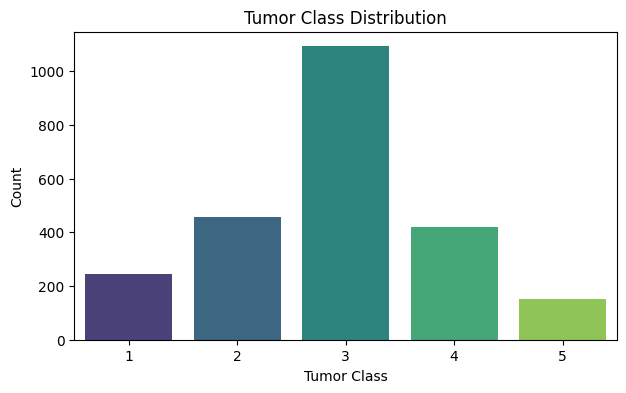

In [38]:
full_images, nodule_images, labels = load_all_images()
df_images = pd.read_excel("/kaggle/input/ds-lung-tumor/dataset_lung.xlsx") # Read the CSV file
class_counts = df_images['TumorClass'].value_counts() # Return a Series containing the frequency of each distinct row in the Dataframe.
print("\nClass Distribution:")
print(class_counts)

plt.figure(figsize=(7, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Tumor Class Distribution")
plt.xlabel("Tumor Class")
plt.ylabel("Count")
plt.show()

# Display Some Full and Nodule Slices

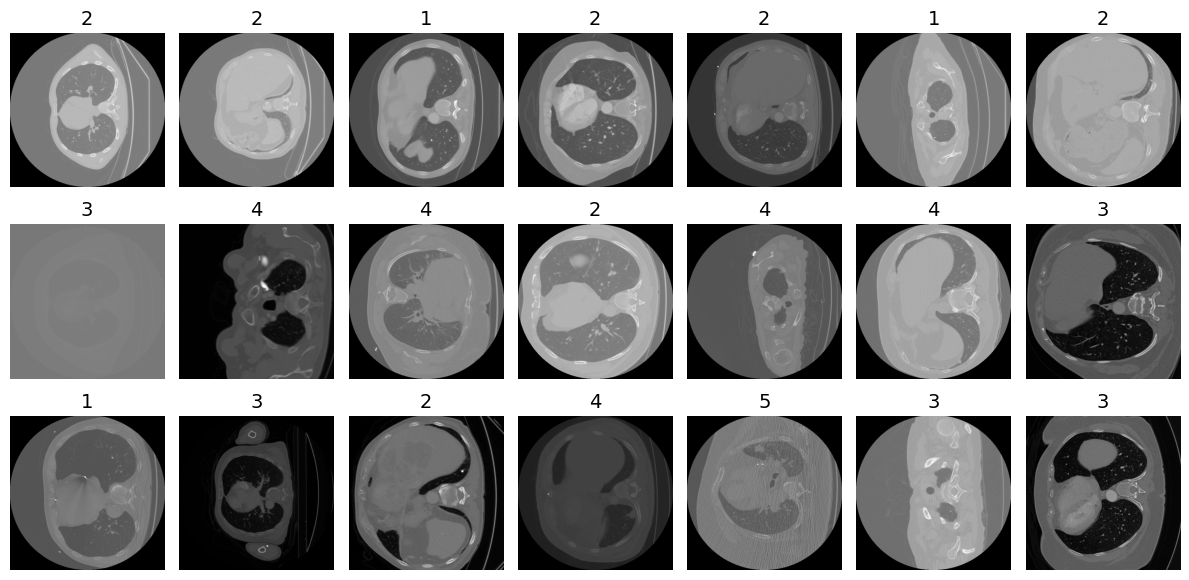

In [39]:
# full_noise_ids = [336, 1595, 1596, 2113]
# full_haze_ids  = [254, 798, 799, 893, 895, 950, 988, 1364, 1630, 1908, 1909, 1935, 2058, 2224]

full_samples_ids = [18, 25, 20, 171, 159, 278, 300, 336, 390, 713, 792, 801,
                   802, 871, 890, 915, 1056, 1086, 1596, 1753, 1976, 2060, 2113, 2224]
labels_ids = []
full_samples = []
for idx, img in enumerate(full_images):
    if idx in full_samples_ids:
        full_samples.append(img)
        labels_ids.append(idx)
    
plot_chunck_images(full_samples, labels_ids)

21


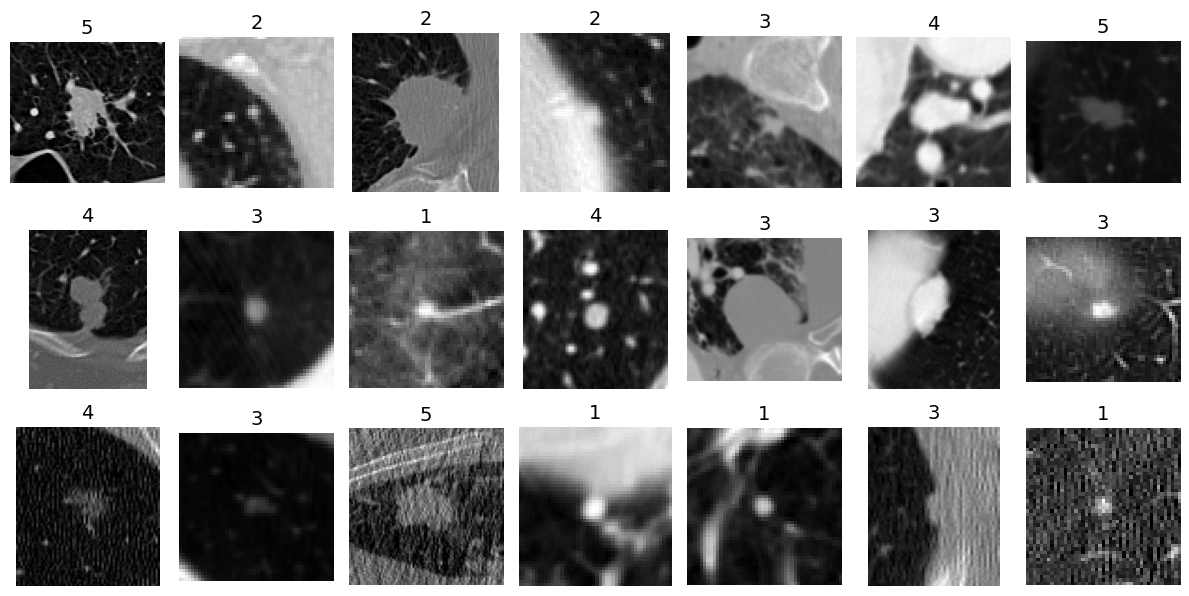

In [40]:
# nodule_noise_ids = [802, 1073, 1144, 1166, 1364, 1595, 1596, 1613]
# nodule_haze_ids  = []
labels_ids = []
nodule_samples = []
nodule_samples_ids = [14, 20, 87, 67, 92, 180, 135, 189, 295, 304, 497, 616, 488, 750, 
                     791, 1509, 1596, 1878, 2018, 2308, 2356]
for idx, img in enumerate(nodule_images):
    if idx in nodule_samples_ids:
        nodule_samples.append(img)
        labels_ids.append(idx)

print(len(nodule_samples_ids))
plot_chunck_images(nodule_samples, labels_ids)

527
['(101, 101)' '(101, 83)' '(103, 112)' '(103, 80)' '(103, 91)'
 '(104, 104)' '(104, 93)' '(105, 104)' '(105, 107)' '(105, 94)'
 '(107, 70)' '(107, 92)' '(108, 104)' '(108, 106)' '(108, 93)' '(109, 94)'
 '(109, 99)' '(111, 70)' '(124, 108)' '(126, 79)' '(44, 45)' '(45, 45)'
 '(45, 46)' '(45, 47)' '(45, 48)' '(45, 50)' '(46, 45)' '(46, 46)'
 '(46, 47)' '(46, 48)' '(46, 49)' '(46, 50)' '(46, 52)' '(47, 46)'
 '(47, 47)' '(47, 48)' '(47, 49)' '(47, 50)' '(47, 51)' '(47, 52)'
 '(47, 53)' '(48, 45)' '(48, 46)' '(48, 47)' '(48, 48)' '(48, 49)'
 '(48, 50)' '(48, 51)' '(48, 52)' '(48, 53)' '(48, 54)' '(48, 55)'
 '(48, 60)' '(48, 61)' '(49, 46)' '(49, 47)' '(49, 48)' '(49, 49)'
 '(49, 50)' '(49, 51)' '(49, 52)' '(49, 53)' '(49, 55)' '(50, 46)'
 '(50, 47)' '(50, 48)' '(50, 49)' '(50, 50)' '(50, 51)' '(50, 52)'
 '(50, 53)' '(50, 54)' '(50, 55)' '(50, 56)' '(50, 57)' '(50, 60)'
 '(51, 46)' '(51, 47)' '(51, 48)' '(51, 49)' '(51, 50)' '(51, 51)'
 '(51, 52)' '(51, 53)' '(51, 54)' '(51, 55)' '(51, 5

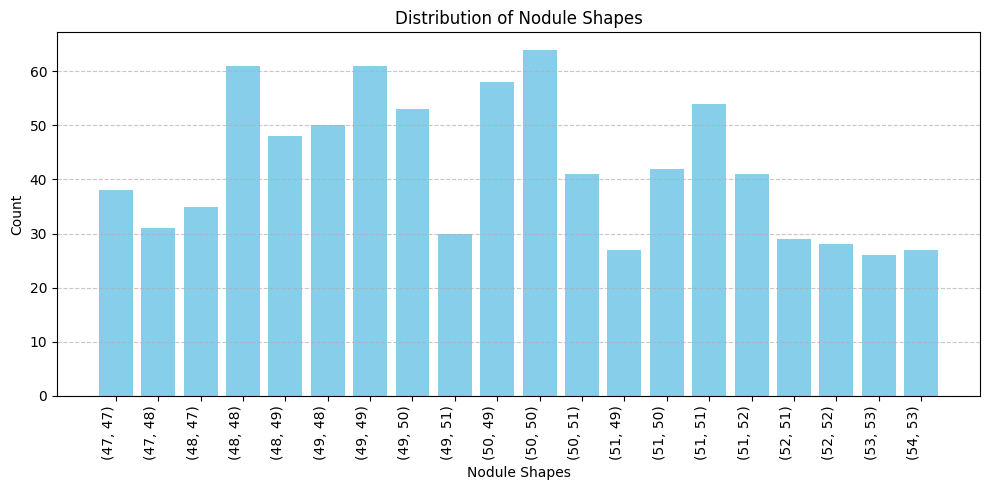

In [41]:
df_dataset = pd.read_csv("/kaggle/input/ds-lung-tumor/dataset_lung_augmented.csv") # Read the CSV file
unique_nodule, count_nodule = np.unique(df_dataset['nodule_shape'], return_counts=True)
print(len(unique_nodule))
print(unique_nodule)
print(count_nodule)

n = 25
nodules_major = count_nodule[count_nodule > n]
indices = np.where(count_nodule > n)[0]

x = unique_nodule[indices]
y = count_nodule[indices]

# Create the bar plot
plt.figure(figsize=(10, 5))  # Adjust figure size as needed
plt.bar(x, y, color='skyblue')

# Add labels and title
plt.xlabel("Nodule Shapes")
plt.ylabel("Count")
plt.title("Distribution of Nodule Shapes")

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=90, ha='right')

# Add grid lines (optional)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

# Data Preprocessing

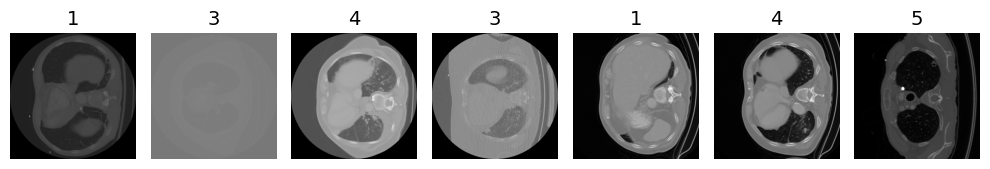

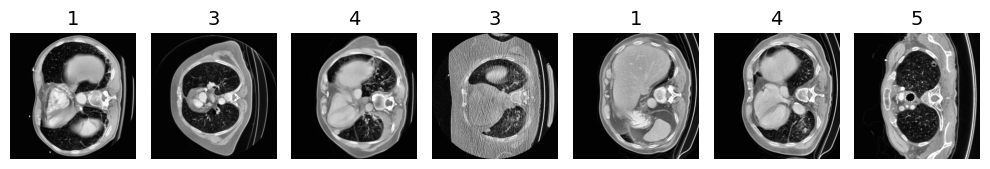

In [42]:
# full_noise_ids = [336, 1595, 1596, 2113]
# full_haze_ids  = [254, 798, 799, 893, 895, 950, 988, 1364, 1630, 1908, 1909, 1935, 2058, 2224]
full_haze_ids  = [254, 336, 895, 1364, 1908, 1909, 2361]

labels_ids = []
full_samples = []
for idx, img in enumerate(full_images):
    if idx in full_haze_ids:
        full_samples.append(img)
        labels_ids.append(idx)

plot_temp_images(full_samples, labels_ids)

min_hu = -1000
max_hu = +500
# wc = -600
# ww = 1500
full_modified_slices = []
for img in full_samples:

    # Mist reduction and gamma transformation
    temp_slice = np.clip(img, min_hu, max_hu)
    temp_slice = cv2.normalize(temp_slice, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    temp_slice = gamma_transform(temp_slice, gamma=1.35)
    
    # Apply Adaptive Contrast Equalization
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    temp_slice = np.uint8(temp_slice)
    temp_slice = clahe.apply(temp_slice)
    
    full_modified_slices.append(temp_slice)

plot_temp_images(full_modified_slices, labels_ids)

# full_slices = np.array(full_modified_slices)

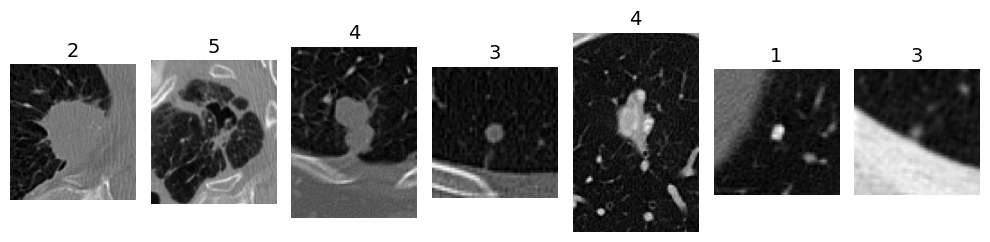

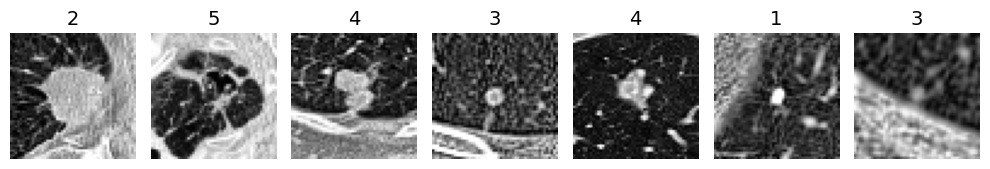

In [49]:
nodule_noise_ids = [67, 172, 189, 214, 281, 426, 833]
# nodule_noise_ids = [187, 1052, 392, 189, 569, 1123, 233]

# nodule_haze_ids  = []
labels_ids = []
nodule_samples = []
# nodule_samples_ids = [14, 20, 87, 67, 92, 180, 135, 189, 295, 304, 497, 616, 488, 750, 
#                      791, 1509, 1596, 1878, 2018, 2308, 2356]
for idx, img in enumerate(nodule_images):
    if idx in nodule_noise_ids:
        nodule_samples.append(img)
        labels_ids.append(idx)
        
plot_temp_images(nodule_samples, labels_ids)

min_hu = -1000
max_hu = +500
# wc = -600
# ww = 1500
nodule_modified_slices = []
for img in nodule_samples:

    # Mist reduction and gamma transformation
    temp_slice = np.clip(img, min_hu, max_hu)
    temp_slice = cv2.normalize(temp_slice, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    temp_slice = gamma_transform(temp_slice, gamma=1.35)
    
    # Apply Adaptive Contrast Equalization
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
    temp_slice = np.uint8(temp_slice)
    temp_slice = clahe.apply(temp_slice)
    
    temp_slice = cv2.resize(temp_slice, (52, 52))

    nodule_modified_slices.append(temp_slice)

plot_temp_images(nodule_modified_slices, labels_ids)

In [ ]:
min_hu = -1000
max_hu = +500
full_all_modified_slices = []
for img in full_images:

    # Mist reduction and gamma transformation
    temp_slice = np.clip(img, min_hu, max_hu)
    temp_slice = cv2.normalize(temp_slice, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    temp_slice = gamma_transform(temp_slice, gamma=1.35)
    
    # Apply Adaptive Contrast Equalization
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    temp_slice = np.uint8(temp_slice)
    temp_slice = clahe.apply(temp_slice)

    full_all_modified_slices.append(temp_slice)

offsets = list(range(0, 2400, 100))
for offset in offsets:
    plot_all_images(full_all_modified_slices, offset)

In [ ]:
min_hu = -1000
max_hu = +500
nodule_all_modified_slices = []
for img in nodule_images:

    # Mist reduction and gamma transformation
    temp_slice = np.clip(img, min_hu, max_hu)
    temp_slice = cv2.normalize(temp_slice, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    temp_slice = gamma_transform(temp_slice, gamma=1.35)
    
    # Apply Adaptive Contrast Equalization
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
    temp_slice = np.uint8(temp_slice)
    temp_slice = clahe.apply(temp_slice)
    
    temp_slice = cv2.resize(temp_slice, (52, 52))

    nodule_all_modified_slices.append(temp_slice)
    
offsets = list(range(0, 2400, 100))
for offset in offsets:
    plot_all_images(nodule_all_modified_slices, offset)

In [ ]:
full_images_1 = extract_images(full_images, 1, labels)
full_images_2 = extract_images(full_images, 2, labels)
full_images_3 = extract_images(full_images, 3, labels)
full_images_4 = extract_images(full_images, 4, labels)
full_images_5 = extract_images(full_images, 5, labels)

full_images_1 = np.array(full_images_1)
full_images_2 = np.array(full_images_2)
full_images_3 = np.array(full_images_3)
full_images_4 = np.array(full_images_4)
full_images_5 = np.array(full_images_5)
